## Titanic Data Exploration

In this project we will investigate the data regarding the Titanic tragedy, aiming to reveal which factors made passengers more likely to survive.


## Question
### Which factors made passengers more likely to survive to the Titanic tragedy?

First, we need to load our libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image  
import pydotplus
from sklearn import tree

%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
titanicData = pd.read_csv('titanic-data.csv')
malePopulation = titanicData.Sex.value_counts()[0]
femalePopulation = titanicData.Sex.value_counts()[1]
ageDistribution = titanicData.Age.value_counts()
classDistribution = titanicData.Pclass.value_counts()

Ok, everything sounds good but we need to clarify what each variable mean:
   * Passenger Id: exclusive identification of the passenger. Should not have duplicates;
   * Survived: Whether the passenger survived(1) or not(0);
   * Pclass: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class);
   * Name: Name of passenger;
   * Sex: Sex of the passenger;
   * Age: Age of the passenger;
   * SibSp: Number of siblings and spouses of the passenger aboard;
   * Parch: Number of parents and children of the passenger aboard;
   * Ticket: Ticket number of the passenger;
   * Fare: Fare paid by the passenger;
   * Cabin: Cabin number of the passenger;
   * Embarked: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton).

# Data Wrangling

From the available variables, Passenger ID should not be relevant for our analysis as it seems to be only an alternative to the name itself. The name on the other hand could be useful if we either analyzed the strings to filter for titles like Dr or Ms or had a second database with more information and use the names to link both. As for this analysis, both the name and passengerId will be supressed. 

In [3]:
import re
def splitDenominator(input):
    return re.findall('(\,+\s*[A-Za-z]+.)', input)[0]

titanicData.Name = titanicData.Name.apply(lambda x: splitDenominator(x))

As embarked, sex and Pclass are categorical features, replacing the strings with values would add imprecise information, as we would be changing a categorical variable to a numerical one. This change would add relations such as one class being more important than other by the sole relation of the numbers chosen.

In [4]:
titanicData = pd.get_dummies(titanicData, columns=['Embarked', 'Sex', 'Name', 'Pclass'], dummy_na=True)

Ticket variables have some letters with the strings, which should be removed to allow easier processing.

In [5]:
titanicData.Ticket.replace('[A-Z]', '', inplace=True, regex=True)
titanicData.Ticket.replace('^[0-9]+\\s[0-9]*\\s*[0-9]*\\s*', '', inplace=True, regex=True)

Now we have to see of there are cells without an actual value and deal with them.

In [6]:
titanicData.isnull().sum().sort_values(ascending=False)

Cabin               687
Age                 177
Pclass_nan            0
Embarked_Q            0
Name_, Capt.          0
Sex_nan               0
Sex_male              0
Sex_female            0
Embarked_nan          0
Embarked_S            0
Embarked_C            0
Name_, Don.           0
Fare                  0
Ticket                0
Parch                 0
SibSp                 0
Survived              0
Name_, Col.           0
Name_, Dr.            0
Pclass_3.0            0
Name_, Jonkheer.      0
Pclass_2.0            0
Pclass_1.0            0
Name_nan              0
Name_, the            0
Name_, Sir.           0
Name_, Rev.           0
Name_, Ms.            0
Name_, Mrs.           0
Name_, Mr.            0
Name_, Mme.           0
Name_, Mlle.          0
Name_, Miss.          0
Name_, Master.        0
Name_, Major.         0
Name_, Lady.          0
PassengerId           0
dtype: int64

Ok, for cabins without value, there isn't much to be done as we don't have the historical records to fill this information and, as there are a total of 891 cases and 687 of them doesn't have a cabin, the cabin feature can be dropped withou much loss of information. As for the age, there are 177 occurences of Not a number. For these we could add the average age hoping to regain some of the lost information.

In [7]:
titanicData = titanicData.drop('Cabin', axis=1)
titanicData.Age.fillna(titanicData.Age.mean(), inplace=True)
titanicData.isnull().sum().sort_values(ascending=False)

Pclass_nan          0
Pclass_3.0          0
Name_, Col.         0
Name_, Capt.        0
Sex_nan             0
Sex_male            0
Sex_female          0
Embarked_nan        0
Embarked_S          0
Embarked_Q          0
Embarked_C          0
Fare                0
Ticket              0
Parch               0
SibSp               0
Age                 0
Survived            0
Name_, Don.         0
Name_, Dr.          0
Name_, Jonkheer.    0
Name_, Ms.          0
Pclass_2.0          0
Pclass_1.0          0
Name_nan            0
Name_, the          0
Name_, Sir.         0
Name_, Rev.         0
Name_, Mrs.         0
Name_, Lady.        0
Name_, Mr.          0
Name_, Mme.         0
Name_, Mlle.        0
Name_, Miss.        0
Name_, Master.      0
Name_, Major.       0
PassengerId         0
dtype: int64

Now we can remove the survived featyure from the main dataframe as this is the feature we want to predict.

In [8]:
titanicDataResults = titanicData['Survived']
titanicDataFeatures = titanicData.drop('Survived', axis=1)
titanicDataFeatures = titanicDataFeatures.drop('Ticket', axis=1)

# Data Exploration

Before we start exploring the data, it is good to remember the question we want to answer: Which factors made passengers more likely to survive to the Titanic tragedy?

With that in mind, we can check some different attributes and their relation with survivability rate.

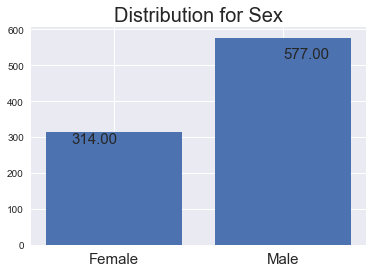

In [9]:
plt.xticks([1,2], ['Female', 'Male'], fontsize=15)
plt.bar( [1,2],  [titanicDataFeatures.Sex_female.sum(), titanicDataFeatures.Sex_male.sum()],)
plt.title('Distribution for Sex', fontsize=20)
ax = plt.axes()
for patch in ax.patches:
    ax.annotate('{0:.2f}'.format(patch.get_height()), (patch.get_x() * 1.25, patch.get_height() * .90), fontsize=15)

By looking at the distribution, it is clear that the majority of the population is composed mostly by men. But did men porportionally survive more than women?

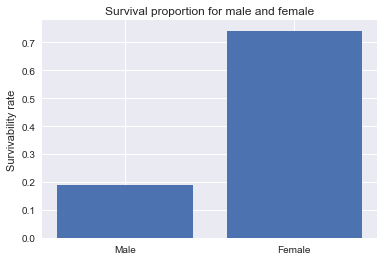

In [10]:
survived = titanicData[titanicData['Survived'] == 1]
sexSurvived = [(survived.Sex_male.value_counts()[1]/float(malePopulation)), 
               survived.Sex_female.value_counts()[1]/float(femalePopulation)]
plt.bar(np.arange(2), sexSurvived)
plt.xticks([0, 1], ['Male', 'Female'])
plt.title('Survival proportion for male and female')
plt.ylabel('Survivability rate')

It is clear that women are much more likely to survive, at least on the population sample we are considering. This could be related to having less women than men on the considered population.

A next factor to consider is age, how is our population distributed regarding age?

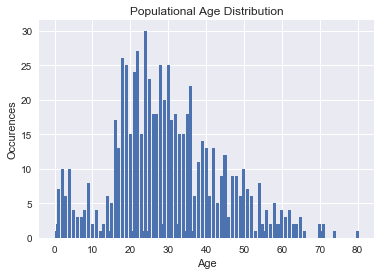

In [11]:
plt.bar(ageDistribution.keys(), ageDistribution.values)
plt.ylabel('Occurences')
plt.title('Populational Age Distribution')
plt.xlabel('Age')

The age of the population is well distributed with the majority of the population ranging from 20 to 30 years. Nos we can chack the survivability rate along the ages.

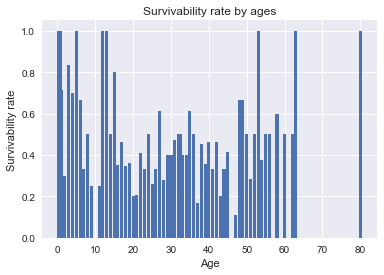

In [12]:
ageSurvivedDistribution = survived.Age.value_counts()
ageSurvivability = ageSurvivedDistribution/ ageDistribution
ageSurvivability.fillna(0, inplace=True)
plt.bar(ageSurvivability.keys(), ageSurvivability.values)
plt.ylabel('Survivability rate')
plt.title('Survivability rate by ages')
plt.xlabel('Age')

The ages with the majority of the population have the smallest survivability rate, which could be either related to the phenomena that actually happened or to our population being unbalanced between ages.

As a different approach, we can use a somewhat unconventional approach and start by analyzing the results of a Decision tree model applied to the whole set. This model wouldn't be useful for correctly predicting new samples as it would most likely be overfitted but it should provide a good and easy to understand overall on the factors which led people to survive.

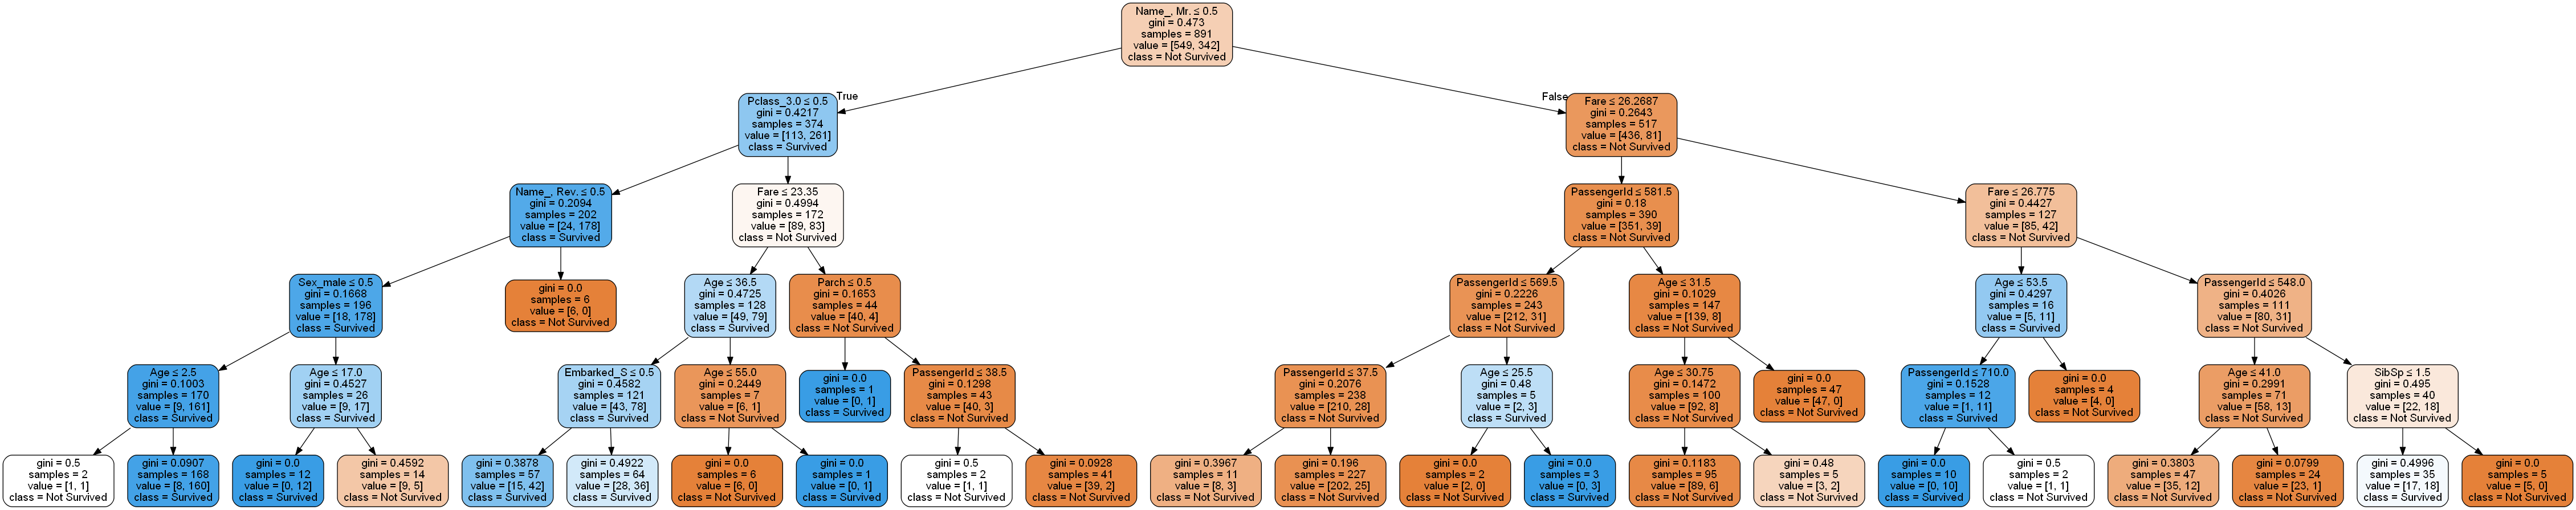

In [13]:
classifier = tree.DecisionTreeClassifier(max_depth=5)

classifier = classifier.fit(titanicDataFeatures , titanicDataResults)


dot_data = tree.export_graphviz(classifier, out_file=None, 
                         feature_names=titanicDataFeatures.columns.values,  
                         class_names=['Not Survived', 'Survived'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Good, our classifier mapped the most important factors by splitting the set based on them. First, there is a split related to Sex (being called Mr. is related to being a man), as women are considered on the right and men on the left. Then, comes the socio-economic class, followed by fare and age. Additionally, the number of siblings or parents or port of embark doesn't seem to have much relevance, as they are responsible for separation on just a few cases.

To evaluate and explain better what was seen on the decision tree clasifier result, we can the correlation between the features and survival rates.

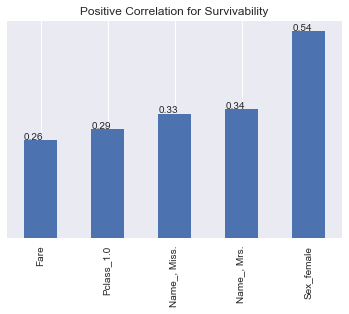

In [14]:
correlation = titanicDataFeatures.corrwith(titanicDataResults).dropna().sort_values()[-5:]
ax = correlation.plot.bar()
ax.set_title('Positive Correlation for Survivability')
ax.set_yticks([])
for patch in ax.patches:
    ax.annotate('{0:.2f}'.format(patch.get_height()), (patch.get_x() * 1.005, patch.get_height() * 1.005))



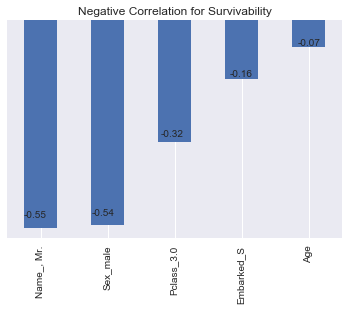

In [15]:
correlation = titanicDataFeatures.corrwith(titanicDataResults).dropna().sort_values()[:5]
ax = correlation.plot.bar()
ax.set_title('Negative Correlation for Survivability')
ax.set_yticks([])
for patch in ax.patches:
    ax.annotate('{0:.2f}'.format(patch.get_height()), (patch.get_x() * 1.025, patch.get_height() * .95))

Investigating the correlation between the features and the survivability, we can clearly note that women were much more likely to survive, either being called by Mrs or Miss. Analogous to this, we can note that men called Mr. were much less likely to survive. Other factor linked to surviving was being rich, contrasting with being poor which was associated to not surviving.

# Conclusion

It is important to note that any conclusions taken from this project are based only on the sample data considered. This sample data may have been chosen to create an intentional bias, as its acquisition proccess isn't clear. This analysis allows us to conclude that rich women were the group most likely to survive to the Titanic tragedy. The other factors available on the dataset didn't have as much relevant as these ones. This result could be somewhat expected as people from the higher classes could imposed themselves as being more important than others for their richness. Additionally, women at that time were considered more fragile and it was a men's duty to protect them, which could induce men to allow women to escape first. 
Finally, it was surprising that the number of siblings and parents did not have much effect on the survival.